In [1]:
import numpy as np
import cPickle
import cv2
import glob
import os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

from utils.template_match_target import *

In [2]:
def get_im_cv2(path, img_width, img_height):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    #resized = cv2.resize(img, (img_width, img_height))#, cv2.INTER_LINEAR)
    return img

def load_data(path, data_type, img_width, img_height):
    X, X_id, y = [], [], []
    minpix = 2                                  #minimum number of pixels for crater to count
    files = glob.glob('%s*.png'%path)
    minpix, maxpix = 2, 100                          #minimum pixels required for a crater to register in an image
    print "number of %s files are: %d"%(data_type,len(files))
    for f in files:
        flbase = os.path.basename(f)
        img = get_im_cv2(f,img_width,img_height) / 255.
        X.append(img)
        y.append(np.array(Image.open('%smask.tiff'%f.split('.png')[0])))
        X_id.append(int(flbase.split('lola_')[1].split('.png')[0]))
        
        #csv = pd.read_csv('%s.csv'%f.split('.png')[0])
        #csv = csv[(csv['Diameter (pix)'] < maxpix) & (csv['Diameter (pix)'] > minpix)]
        #target = mdm.make_mask(csv, img, binary=True, truncate=True, rings=True)
        #target = mdm.make_circlering_mask(csv, img, binary=True, truncate=True)
        #target = mdm.make_mask(csv, img, binary=True, rings=True, ringwidth=1, truncate=True)
        #y.append(target)
    return  X, y, X_id

def read_and_normalize_data(path, img_width, img_height, data_flag):
    if data_flag == 0:
        data_type = 'train'
    elif data_flag == 1:
        data_type = 'test'
    data, target, id_ = load_data(path, data_type, img_width, img_height)
    data = np.array(data).astype('float32')     #convert to numpy, convert to float
    data = data.reshape(len(data),img_width,img_height,1)
    target = np.array(target).astype('float32')
    print('%s shape:'%data_type, data.shape)
    return data, target, id_

#save target no border for Hough circles
def save_image(data, cm, fn):
    sizes = np.shape(data)
    height = float(sizes[0])
    width = float(sizes[1])
    fig = plt.figure()
    fig.set_size_inches(width/height, 1, forward=False)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(data, cmap=cm)
    plt.savefig(fn, dpi = height) 
    
def rescale_and_invcolor(data, inv_color, rescale):
    for img in data:
        if inv_color == 1:
            img[img > 0.] = 1. - img[img > 0.]
        if rescale == 1:
            minn, maxx = np.min(img[img>0]), np.max(img[img>0])
            low, hi = 0.1, 1                                                #low, hi rescaling values
            img[img>0] = low + (img[img>0] - minn)*(hi - low)/(maxx - minn) #linear re-scaling
    return data

In [3]:
dim, inv_color, rescale = 256, 1, 1
train_data, train_target, train_id = read_and_normalize_data('datasets/rings/Train_rings/', dim, dim, 0)
test_data, test_target, test_id = read_and_normalize_data('datasets/rings/Test_rings/', dim, dim, 1)

#invcolor and rescale
if inv_color==1 or rescale==1:
    train_data = rescale_and_invcolor(train_data, inv_color, rescale)
    test_data = rescale_and_invcolor(test_data, inv_color, rescale)

number of train files are: 20
('train shape:', (20, 256, 256, 1))
number of test files are: 40
('test shape:', (40, 256, 256, 1))


In [4]:
from keras.models import load_model

Using TensorFlow backend.


In [5]:
filename = 'models/unet_s256_rings_predfull_FL5_glorot_normal.h5'
model = load_model(filename)

In [6]:
n,off=5,0
target = model.predict(test_data[off:(n+off)].astype('float32'))
target_ids = test_id[off:(n+off)]

In [7]:
#convert pixel radius to absolute
P = cPickle.load(open('datasets/rings/lolaout_test.p', 'r'))

master_img_height_pix = 20000.  #number of pixels for height
master_img_height_lat = 180.
R_moon = 1737                    #radius of the moon (km)
olen = 256                       #output length (pixels)

In [42]:
P[0]['llbd']

array([ 154.1484375,  160.9921875,   25.9609375,   32.8046875])

# there's a problem here where the radii are all exactly the same!! Bug somewhere

[[  364.375        518.421875       2.4556259 ]
 [ 1099.140625     569.984375       3.27416786]
 [ 1047.578125    1162.953125       2.4556259 ]
 [  312.8125      1272.5234375      2.4556259 ]
 [ 1646.9921875   1278.96875        3.27416786]
 [ 1627.65625       22.1328125      4.09270983]
 [ 1640.546875     692.4453125      4.09270983]
 [ 1331.171875     692.4453125      4.09270983]
 [ 1550.3125       750.453125       4.09270983]
 [ 1389.1796875    782.6796875      4.09270983]
 [  299.921875    1562.5625         3.27416786]
 [ 1221.6015625    363.734375       4.09270983]
 [  712.421875     557.09375        4.09270983]
 [ 1389.1796875    686.             4.09270983]
 [ 1569.6484375    698.890625       4.9112518 ]
 [  963.7890625    563.5390625      4.9112518 ]
 [  641.5234375    782.6796875      4.9112518 ]
 [  351.484375    1433.65625        4.9112518 ]
 [ 1627.65625      769.7890625      5.72979376]
 [  738.203125     892.25           7.36687769]
 [  989.5703125    866.46875       10.64

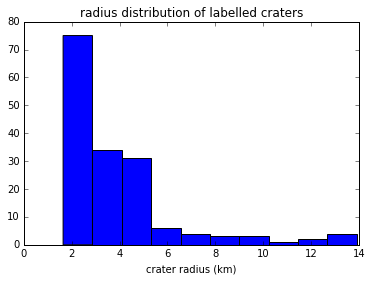

In [49]:
#code for checking that a discovered crater is new, and hasn't been already discovered in another image.
match_thresh2 = 50.
dim = 256.
pred_crater_dist = np.empty([0,3])
for i in range(1):
    coords = template_match_target(target[i])
    P_ = P[test_id[i]]
    #mask = np.zeros((dim,dim))
    img_pix_height = P_['box'][2] - P_['box'][0]
    pix_to_km = (master_img_height_lat/master_img_height_pix)*(np.pi/180)*(img_pix_height/olen)*R_moon
    long_pix,lat_pix,radii_pix = coords.T
    radii_km = radii_pix*pix_to_km
    long_deg = P_['llbd'][0] + (P_['llbd'][1]-P_['llbd'][0])*(long_pix/dim)
    lat_deg = P_['llbd'][3] - (P_['llbd'][3]-P_['llbd'][2])*(lat_pix/dim)
    
    tuple_ = np.column_stack((long_deg,lat_deg,radii_km))
    print tuple_  #there's a problem here where the radii are all exactly the same!! Bug somewhere
    if len(pred_crater_dist > 0):
        j, N = 0, len(tuple_)
        #remove duplicates
        while j < N:
            diff = (pred_crater_dist - tuple_[j])**2
            diffsum = np.asarray([sum(x) for x in diff])
            index = diffsum < match_thresh2
            if len(np.where(index==True)[0]) > 0:
                print tuple_[j], pred_crater_dist[index]
                tuple_ = np.delete(tuple_,j,axis=0)
                N = len(tuple_)
            else:
                j += 1
    print i
    pred_crater_dist = np.concatenate((pred_crater_dist,tuple_))
    
plt.hist(master_radii_dist, 10)
plt.title('radius distribution of labelled craters')
plt.xlabel('crater radius (km)')

In [39]:
pred_crater_dist[i]

array([ 1646.9921875 ,  1278.96875   ,     3.27416786])

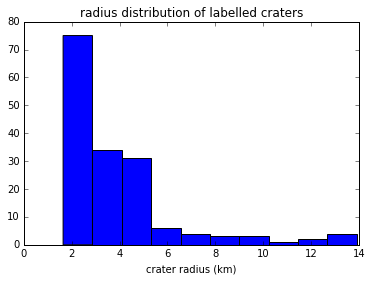

In [71]:
plt.hist(master_radii_dist, 10)
plt.title('radius distribution of labelled craters')
plt.xlabel('crater radius (km)')